In [1]:
import pandas as pd

corona_train_df = pd.read_csv('../data/ML-A2/Corona_train.csv')
corona_validation_df = pd.read_csv('../data/ML-A2/Corona_validation.csv')

corona_train_df.head()

,ID,Sentiment,CoronaTweet
0,22979,Positive,I see all kinds of academics already whipping ...
1,9880,Negative,@HenrySmithUK can you raise with Boris please ...
2,35761,Negative,It s a confusing odd time for the shopping pub...
3,37968,Positive,Blog Summary: The Impact of COVID-19 on the Ca...
4,19709,Neutral,??????? ??????? ???\r\r\nWaiting in a long Que...


In [12]:
twitter_train_df = pd.read_csv('../data/ML-A2/Domain_Adaptation/Twitter_train_1.csv')
twitter_train_df.head()

,ID,Sentiment,Tweet
0,12,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM..."
1,13,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM..."
2,14,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM..."
3,15,Neutral,"Rock-Hard La Vita, RARE BUT POWERFUL, HANDSOME..."
4,16,Neutral,"Live Rock - Hard music La la Varlope, RARE & t..."


In [13]:
corona_train_df = pd.concat([corona_train_df, twitter_train_df])
corona_train_df.head()

,ID,Sentiment,CoronaTweet,Tweet,Tokens,AdvancedTokens
0,22979,Positive,I see all kinds of academics already whipping ...,NaN,"[i, see, all, kinds, of, academics, already, w...","[see, kind, academ, alreadi, whip, #covid_19, ..."
1,9880,Negative,@HenrySmithUK can you raise with Boris please ...,NaN,"[@henrysmithuk, can, you, raise, with, boris, ...","[@henrysmithuk, rais, bori, pleas, supermarket..."
2,35761,Negative,It s a confusing odd time for the shopping pub...,NaN,"[it, s, a, confusing, odd, time, for, the, sho...","[confus, odd, time, shop, public, store, close..."
3,37968,Positive,Blog Summary: The Impact of COVID-19 on the Ca...,NaN,"[blog, summary:, the, impact, of, covid-19, on...","[blog, summary:, impact, covid-19, canadian, r..."
4,19709,Neutral,??????? ??????? ???\r\r\nWaiting in a long Que...,NaN,"[???????, ???????, ???, waiting, in, a, long, ...","[???????, ???????, ???, wait, long, queue, ent..."


In [30]:
import numpy as np
import re
from collections import Counter
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

classes = ['Positive', 'Negative', 'Neutral']

def naive_bayes(training_df, validation_df):
    corona_train_df = training_df
    corona_validation_df = validation_df
    
    def preprocess_text(text):
        """Preprocess the text data by converting to lowercase, removing special characters and tokenizing."""
        text = str(text)
        text = text.lower()
        text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
        tokens = text.split()
        return tokens
    
    corona_train_df['Tokens'] = corona_train_df['CoronaTweet'].apply(preprocess_text)
    corona_validation_df['Tokens'] = corona_validation_df['CoronaTweet'].apply(preprocess_text)
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    def advanced_preprocess_text(tokens):
        """Remove stopwords and perform stemming on the tokens."""
        # Remove stopwords
        filtered_tokens = [token for token in tokens if token not in stop_words]
        
        # Perform stemming
        stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
        
        return stemmed_tokens
    
    corona_train_df['AdvancedTokens'] = corona_train_df['Tokens'].apply(advanced_preprocess_text)
    corona_validation_df['AdvancedTokens'] = corona_validation_df['Tokens'].apply(advanced_preprocess_text)
    
    # Learn a new model on the transformed data and calculate accuracy on training and validation datasets.
    
    prior_probabilities = {}
    word_given_class_probabilities = {}
    
    # Calculate prior probabilities for each class
    for class_label in classes:
        prior_probabilities[class_label] = len(corona_train_df[corona_train_df['Sentiment'] == class_label]) / len(corona_train_df)
    
    all_tokens = [token for sublist in corona_train_df['AdvancedTokens'].tolist() for token in sublist]
    vocabulary = Counter(all_tokens)
    
    # Calculate word_given_class probabilities (with Laplace smoothing) for each class
    for class_label in classes:
        # Extract tokens for the current class
        tokens_in_class = [token for sublist in corona_train_df[corona_train_df['Sentiment'] == class_label]['AdvancedTokens'].tolist() for token in sublist]
        token_counts_in_class = Counter(tokens_in_class)
        
        # Calculate probabilities using Laplace smoothing
        word_given_class_probabilities[class_label] = {}
        for word in vocabulary:
            word_given_class_probabilities[class_label][word] = np.log((token_counts_in_class[word] + 1) / (len(tokens_in_class) + len(vocabulary)))
    
    prior_probabilities, {key: word_given_class_probabilities['Positive'][key] for key in list(word_given_class_probabilities['Positive'])[:5]}  # Displaying first 5 probabilities for 'Positive' class for brevity
    def naive_bayes_predict(tokens, prior_probabilities, word_given_class_probabilities):
        """Predict the class label using Naive Bayes."""
        class_scores = {}
        
        for class_label in prior_probabilities:
            class_scores[class_label] = np.log(prior_probabilities[class_label]) + \
                                        sum(word_given_class_probabilities[class_label].get(token, 0) for token in tokens)
        
        return max(class_scores, key=class_scores.get)
    
    corona_train_df['PredictedSentiment'] = corona_train_df['AdvancedTokens'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))
    corona_validation_df['PredictedSentiment'] = corona_validation_df['AdvancedTokens'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))
    
    train_accuracy = (corona_train_df['Sentiment'] == corona_train_df['PredictedSentiment']).mean()
    validation_accuracy = (corona_validation_df['Sentiment'] == corona_validation_df['PredictedSentiment']).mean()
    
    return train_accuracy, validation_accuracy

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hbot07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
sizes = [1,2,5,10,25,50,100]
train_accuracies = []
validation_accuracies1 = []
df1 = pd.read_csv('../data/ML-A2/Corona_train.csv')
val_df = pd.read_csv('../data/ML-A2/Domain_Adaptation/Twitter_validation.csv')
val_df['CoronaTweet'] = val_df['Tweet']
for size in sizes:
    df2 = pd.read_csv(f'../data/ML-A2/Domain_Adaptation/Twitter_train_{size}.csv')
    df2['CoronaTweet'] = df2['Tweet']
    train_accuracy, validation_accuracy = naive_bayes(pd.concat((df1,df2)), val_df)
    train_accuracies.append(train_accuracy)
    validation_accuracies1.append(validation_accuracy)
    
    print(f'Training accuracy for {size} %: {train_accuracy}')
    print(f'Validation accuracy for {size} %: {validation_accuracy}')
    print()

Training accuracy for 1 %: 0.793391908244331
Validation accuracy for 1 %: 0.4218025182239894
Training accuracy for 2 %: 0.7937847185829577
Validation accuracy for 2 %: 0.42876076872100727
Training accuracy for 5 %: 0.7934945874553271
Validation accuracy for 5 %: 0.4363817097415507
Training accuracy for 10 %: 0.7928564170307896
Validation accuracy for 10 %: 0.4526176275679258
Training accuracy for 25 %: 0.787787763733359
Validation accuracy for 25 %: 0.4777998674618953
Training accuracy for 50 %: 0.7850277753284542
Validation accuracy for 50 %: 0.4960238568588469
Training accuracy for 100 %: 0.7833497276029056
Validation accuracy for 100 %: 0.5255135851557323


In [32]:
validation_accuracies2 = []
for size in sizes:
    df2 = pd.read_csv(f'../data/ML-A2/Domain_Adaptation/Twitter_train_{size}.csv')
    df2['CoronaTweet'] = df2['Tweet']
    train_accuracy, validation_accuracy = naive_bayes(df2, val_df)
    train_accuracies.append(train_accuracy)
    validation_accuracies2.append(validation_accuracy)
    
    print(f'Training accuracy for {size} %: {train_accuracy}')
    print(f'Validation accuracy for {size} %: {validation_accuracy}')
    print()

Training accuracy for 1 %: 0.9333333333333333
Validation accuracy for 1 %: 0.39231278992710406
Training accuracy for 2 %: 0.96
Validation accuracy for 2 %: 0.4039098740888005
Training accuracy for 5 %: 0.9533333333333334
Validation accuracy for 5 %: 0.42312789927104044
Training accuracy for 10 %: 0.95
Validation accuracy for 10 %: 0.44565937707090786
Training accuracy for 25 %: 0.9194666666666667
Validation accuracy for 25 %: 0.4665341285619616
Training accuracy for 50 %: 0.8865333333333333
Validation accuracy for 50 %: 0.49801192842942343
Training accuracy for 100 %: 0.8657333333333334
Validation accuracy for 100 %: 0.5231941683233929


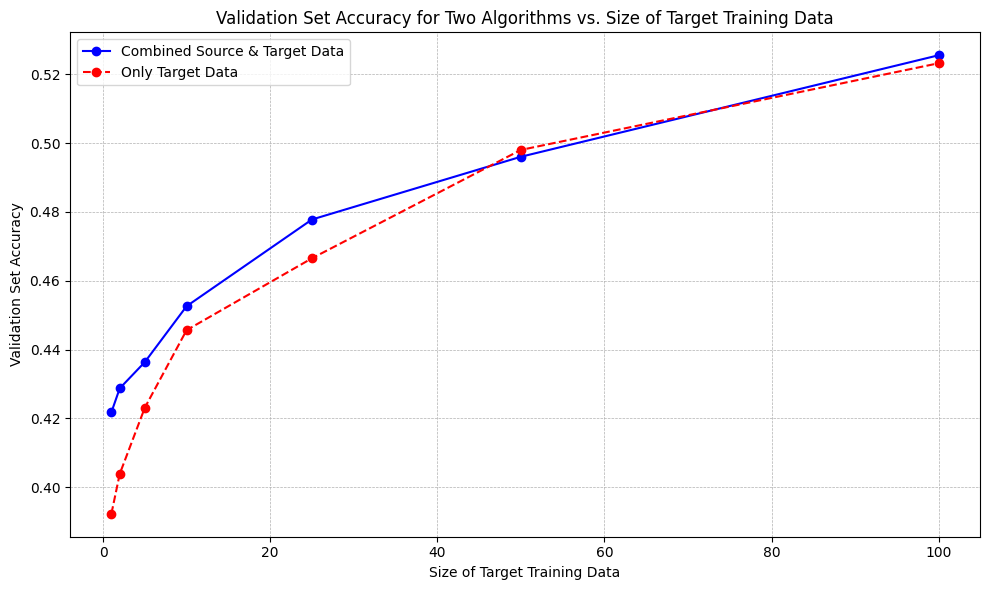

In [34]:
# Plotting the accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(sizes, validation_accuracies1, marker='o', label='Combined Source & Target Data', linestyle='-', color='blue')
plt.plot(sizes, validation_accuracies2, marker='o', label='Only Target Data', linestyle='--', color='red')

# Adding titles and labels
plt.title('Validation Set Accuracy for Two Algorithms vs. Size of Target Training Data')
plt.xlabel('Size of Target Training Data')
plt.ylabel('Validation Set Accuracy')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.savefig('Domain adaptation validation_accuracies plot.png')
plt.show()